<a href="https://colab.research.google.com/github/Deadkiller43/DLMODELS/blob/main/firstModelDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Loading the dataset

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.CIFAR10(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 170M/170M [00:02<00:00, 65.7MB/s]


###Labeling the data in the dataset

In [2]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

###Visualize some samples

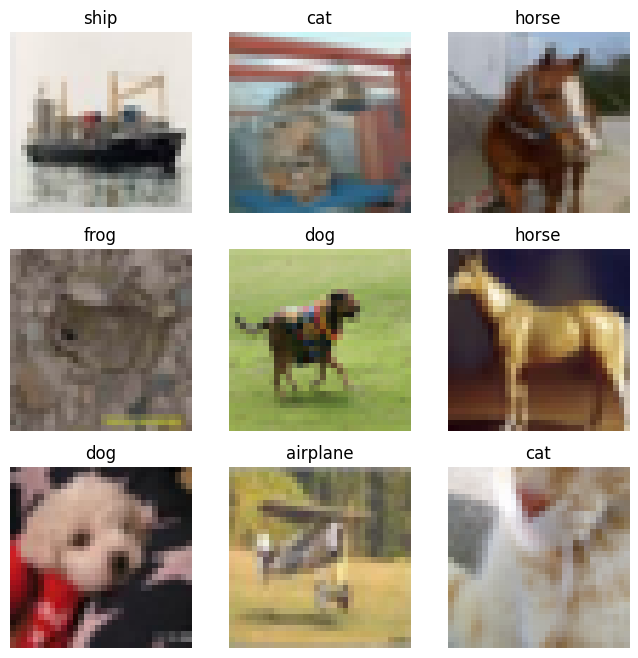

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

###Preparing the data for training with DataLoaders

In [7]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

###Iterate through the DataLoader

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


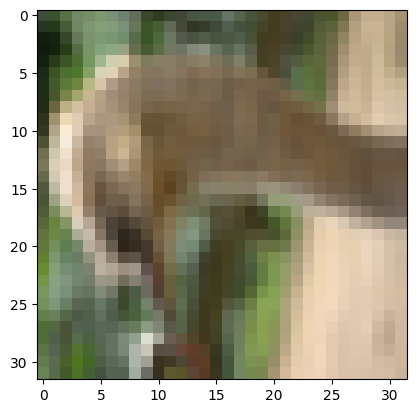

Label: 2


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(2, 1, 0).squeeze())
plt.show()
print(f"Label: {label}")

###Transforms

In [13]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch import nn

ds = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


##Define the class

In [23]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(32*32*3, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [24]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [26]:
X = torch.rand(1, 3, 32, 32, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([7])


###Hyperparameters

In [27]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#Full implementation

In [29]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.312730  [   64/50000]
loss: 2.300035  [ 6464/50000]
loss: 2.297982  [12864/50000]
loss: 2.290065  [19264/50000]
loss: 2.276856  [25664/50000]
loss: 2.280925  [32064/50000]
loss: 2.287294  [38464/50000]
loss: 2.283730  [44864/50000]
Test Error: 
 Accuracy: 16.9%, Avg loss: 2.270057 

Epoch 2
-------------------------------
loss: 2.277504  [   64/50000]
loss: 2.264236  [ 6464/50000]
loss: 2.240971  [12864/50000]
loss: 2.252511  [19264/50000]
loss: 2.250425  [25664/50000]
loss: 2.257551  [32064/50000]
loss: 2.254153  [38464/50000]
loss: 2.242728  [44864/50000]
Test Error: 
 Accuracy: 21.5%, Avg loss: 2.234277 

Epoch 3
-------------------------------
loss: 2.217379  [   64/50000]
loss: 2.229478  [ 6464/50000]
loss: 2.197336  [12864/50000]
loss: 2.218105  [19264/50000]
loss: 2.192877  [25664/50000]
loss: 2.242469  [32064/50000]
loss: 2.171545  [38464/50000]
loss: 2.206383  [44864/50000]
Test Error: 
 Accuracy: 25.2%, Avg loss: 2.183917 

Epoc